In [2]:
import sys

moduleLoc = "../"
if moduleLoc in sys.path: 
    print('woo')
else:
    sys.path.append(moduleLoc)
import matplotlib.pyplot as plt
import tools, analysis
import pandas as pd
import seaborn as sns
import numpy as np
from scipy import stats
import matplotlib.patches as mpatches

# Enable inline plotting
%matplotlib inline

In [4]:
#read tail files into a pd dataframe
import imp
imp.reload(tools)
folderLoc = "/Users/tlsha/Dropbox/NoctData/"
controlName = "siLuc.tails"
KDname = "siNoct.tails"
WTname = "NoctWT.tails"
EAname = "NoctEA.tails"

# Function to read in .tail format file and return a dataframe
control = tools.pdTailMaker(folderLoc+controlName)
print('Control In!')
knockdown = tools.pdTailMaker(folderLoc+KDname)
print('Knockdown In!')
WTaddback = tools.pdTailMaker(folderLoc+WTname)
print('WT In!')
EAaddback = tools.pdTailMaker(folderLoc+EAname)
print('EA In!')

Control In!
Knockdown In!
WT In!
EA In!


In [10]:
# Filter and combine tail data
minTail = -10
maxTail = 10

def filtTails(df, source, minTail, maxTail):
    newDf = df[(df['3Loc']+df['TailLength'])>=minTail]
    newDf = newDf[(newDf['3Loc']+newDf['TailLength'])<=maxTail]
    newDf['Source'] = source
    newDf['TotalTail'] = newDf['3Loc'] + newDf['TailLength']
    return newDf

f_control = filtTails(control, 'siLuc',minTail,maxTail)
f_knockdown = filtTails(knockdown, 'siNoct',minTail,maxTail)
f_WT = filtTails(WTaddback,'WT Addback',minTail,maxTail)
f_EA = filtTails(EAaddback,'EA Addback',minTail,maxTail)


# Combined experimental data
combo = pd.concat([f_control,
                   f_knockdown,
                   f_WT,
                   f_EA],
                  ignore_index=True)

print ("CONTROL\nInitial: {}\nFiltered: {}\n".format(len(control),len(f_control)))
print ("KNOCKDOWN\nInitial: {}\nFiltered: {}\n".format(len(knockdown),len(f_knockdown)))
print ("WT\nInitial: {}\nFiltered: {}\n".format(len(WTaddback),len(f_WT)))
print ("EA\nInitial: {}\nFiltered: {}\n".format(len(EAaddback),len(f_EA)))

combo.set_index('Gene', inplace=True)
combo.to_csv('combo.csv')
combo.head()

CONTROL
Initial: 3903782
Filtered: 1351776

KNOCKDOWN
Initial: 4621080
Filtered: 1324006

WT
Initial: 2411894
Filtered: 759185

EA
Initial: 2579469
Filtered: 779416



,3Loc,TailLength,TailSeq,Type,Source,TotalTail
Gene,,,,,,
RNU1-28P-201,0.0,0.0,,snRNA,siLuc,0.0
RNU1-28P-201,0.0,0.0,,snRNA,siLuc,0.0
RNU1-28P-201,0.0,0.0,,snRNA,siLuc,0.0
RNU1-28P-201,0.0,0.0,,snRNA,siLuc,0.0
RNU1-28P-201,0.0,0.0,,snRNA,siLuc,0.0


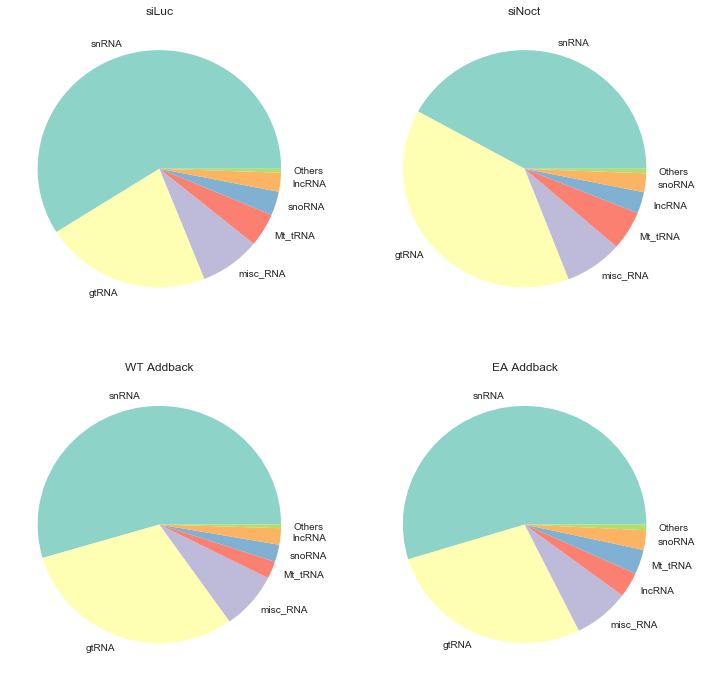

In [11]:
#Plot distribution of mapped reads
f, axarr = plt.subplots(2,2, figsize=(12,12), )
axarr[0,0].set_title("siLuc")
axarr[0,1].set_title("siNoct")
axarr[1,0].set_title("WT Addback")
axarr[1,1].set_title("EA Addback")


def pieMaker (df, column, otheredNum, axis):
    x = list(df[column].value_counts()[:-otheredNum].values)
    others = df[column].value_counts()[-otheredNum:].values
    others = sum(others)
    labels = df[column].value_counts()[:-otheredNum].index.tolist()
    labels += ["Others"]
    colors = sns.color_palette("Set3", 10)
    x +=[others]
    plt.subplot(axis)
    axis = plt.pie(x,labels=labels, colors=colors)

pieMaker(f_control,'Type',4, axarr[0,0])
pieMaker(f_knockdown,'Type',4, axarr[0,1])
pieMaker(f_WT,'Type',4,axarr[1,0])
pieMaker(f_EA,'Type',5,axarr[1,1])


In [57]:
# Create TPM Table and Save to CSV

def TPMmaker(df, source, totalReads):
    df = df.set_index('Gene')
    df.head()
    names = set(df.index)
    out = []
    # 'Gene', 'Source', 'Count', 'TPM'
    for name in names:
        out.append([name,
                    source,
                    df.loc[[name]]['Type'].values[0],
                    len(df.loc[[name]]),
                    len(df.loc[[name]])/(totalReads/1000000)])
    print(source + " finished.")
    return pd.DataFrame(out, columns = ["Gene",'Source','Type','Count','TPM'])

TPM = pd.concat([TPMmaker(f_control,"siLuc",len(control)),
           TPMmaker(f_knockdown, "siNoct", len(knockdown)),
           TPMmaker(f_WT,"WT Addback",len(WTaddback)),
           TPMmaker(f_EA, "EA Addback", len(EAaddback))],
          ignore_index=True)

TPM.to_csv('TPM.csv')

siLuc finished.
siNoct finished.
WT Addback finished.
EA Addback finished.


In [42]:
# Create candidates based on total tail length
df1 = combo[combo['Source']=='siLuc']
df2 = combo[combo['Source']=='siNoct']
df3 = combo[combo['Source']=='WT Addback']
df4 = combo[combo['Source']=='EA Addback']
def findCandidates(df1, df2, pThresh=0.05, minTranscripts=10, minDiff=0.2):
    cans = []
    
    # Build a list of transcripts that are in both sets
    transcripts = list(set(df1.index) & set(df2.index))
    
    i=0
    for tran in transcripts:
        i+=1
        if i%100==0: print(i/len(transcripts))
        df1_reads = df1.loc[[tran],['TotalTail']]
        df2_reads = df2.loc[[tran],['TotalTail']]
        
        #Don't consider reads with less reads than minTranscripts
        if len(df1_reads) < minTranscripts or len(df2_reads) < minTranscripts: continue
        
        #Difference between 2 sets must be statistically significant by at least pThresh by KS test
        p_value = stats.ks_2samp(df1_reads['TotalTail'].values,df2_reads['TotalTail'].values)[1]
        if p_value >pThresh: continue
        
        tran_type = df1.loc[[tran],['Type']].values[0][0]
        df1_count = len(df1_reads.values)
        df1_average = np.average(df1_reads.values)
        df1_stdev = np.std(df1_reads.values)
        df2_count = len(df2_reads.values)
        df2_average = np.average(df2_reads.values)
        df2_stdev = np.std(df2_reads.values)
        
        if abs((df1_average-df2_average)/df1_average) < minDiff: continue

        cans.append([tran,tran_type,df1_count,df1_average,df1_stdev,df2_count,df2_average,df2_stdev,p_value])
    cans = sorted(cans,key=lambda x:x[8])
    return pd.DataFrame(cans, columns = ["Transcript","Transcript Type", "1-Count","1-Average","1-Stdev",
                                        "2-Count","2-Average","2-Stdev","p"]).set_index("Transcript")
        
Luc_Noct_Cans = findCandidates(df1,df2)
Noct_WT_Cans= findCandidates(df2,df3)
WT_EA_Cans= findCandidates(df3,df4)
Luc_EA_Cans= findCandidates(df1,df4)
Luc_WT_Cans= findCandidates(df1,df3)

Luc_Noct_Cans.to_csv('Luc_Noct_Cans.csv')
Noct_WT_Cans.to_csv('Noct_WT_Cans.csv')
WT_EA_Cans.to_csv('WT_EA_Cans.csv')
Luc_EA_Cans.to_csv('Luc_EA_Cans.csv')
Luc_WT_Cans.to_csv('Luc_WT_Cans.csv')


0.12062726176115803
0.24125452352231605
0.3618817852834741
0.4825090470446321
0.6031363088057901
0.7237635705669482
0.8443908323281062
0.9650180940892642
0.13003901170351106
0.26007802340702213
0.39011703511053314
0.5201560468140443
0.6501950585175552
0.7802340702210663
0.9102730819245773
0.1358695652173913
0.2717391304347826
0.4076086956521739
0.5434782608695652
0.6793478260869565
0.8152173913043478
0.9510869565217391
0.13020833333333334
0.2604166666666667
0.390625
0.5208333333333334
0.6510416666666666
0.78125
0.9114583333333334
0.1342281879194631
0.2684563758389262
0.40268456375838924
0.5369127516778524
0.6711409395973155
0.8053691275167785
0.9395973154362416


In [51]:
#Find candidates using TPM, saves candidates based on a maturation hypothesis and a decay hypothesis
matCans = []
decayCans = []
names = list(set(TPM['Gene']))
df1 = TPM[TPM['Source']=='siLuc']
df2 = TPM[TPM['Source']=='siNoct']
df3 = TPM[TPM['Source']=='WT Addback']
df4 = TPM[TPM['Source']=='EA Addback']

for name in names:
    try:
        siLuc = (df1[df1['Gene']==name]['TPM']).values[0]
        siNoct = (df2[df2['Gene']==name]['TPM']).values[0]
        WT = (df3[df3['Gene']==name]['TPM']).values[0]
        EA = (df4[df4['Gene']==name]['TPM']).values[0]
    except:
        continue
    
    #Changes in TPM preicted by different models
    if siLuc > siNoct and siLuc > EA and siNoct < WT and WT > EA: matCans.append([name,siLuc,siNoct,WT,EA])
    if siLuc < siNoct and siLuc < EA and siNoct > WT and WT < EA: decayCans.append([name,siLuc,siNoct,WT,EA])
        
matCans = sorted(matCans, key=lambda x:x[1], reverse=True)
decayCans = sorted(decayCans, key=lambda x:x[1], reverse=True)
        
pd.DataFrame(matCans, columns=['Gene','siLuc','siNoct','WT','EA']).to_csv('Maturation_Candidates.csv')
pd.DataFrame(decayCans, columns=['Gene','siLuc','siNoct','WT','EA']).to_csv('Decay_Candidates.csv')


In [52]:
# Read in from saved CSVs to save hella analysis time. Start from here if you have the CSVs
TPM = pd.read_csv('TPM.csv',index_col=0)
combo = pd.read_csv('combo.csv',index_col=0)

Luc_Noct_Cans = pd.read_csv('Luc_Noct_Cans.csv',index_col=0)
Noct_WT_Cans= pd.read_csv('Noct_WT_Cans.csv',index_col=0)
WT_EA_Cans= pd.read_csv('WT_EA_Cans.csv',index_col=0)
Luc_EA_Cans= pd.read_csv('Luc_EA_Cans.csv',index_col=0)
Luc_WT_Cans= pd.read_csv('Luc_WT_Cans.csv',index_col=0)
can_Arr = [Luc_Noct_Cans,Noct_WT_Cans,WT_EA_Cans,Luc_EA_Cans,Luc_WT_Cans]

mat_cans = pd.read_csv('Maturation_Candidates.csv',index_col=1).drop('Unnamed: 0',axis=1)
dec_cans = pd.read_csv('Decay_Candidates.csv',index_col=1).drop('Unnamed: 0',axis=1)

In [26]:
len(set(TPM[TPM['Type']=='gtRNA']['Gene']))
#307 gtRNA found
len(mat_cans[mat_cans.index.str.contains('Homo')])
#22 in mat_cans
len(dec_cans[dec_cans.index.str.contains('Homo')])
#43 in decay cans

#19 expected by chance

temp = list(set(TPM[TPM['Type']=='gtRNA']['Gene']))

n=0
for i in range(len(temp)):
    if len(TPM[TPM['Gene']==temp[i]]) == 4: n+=1
print(n)
#245 tRNA found in all conditions
#15 would be expected by chance in that case

245


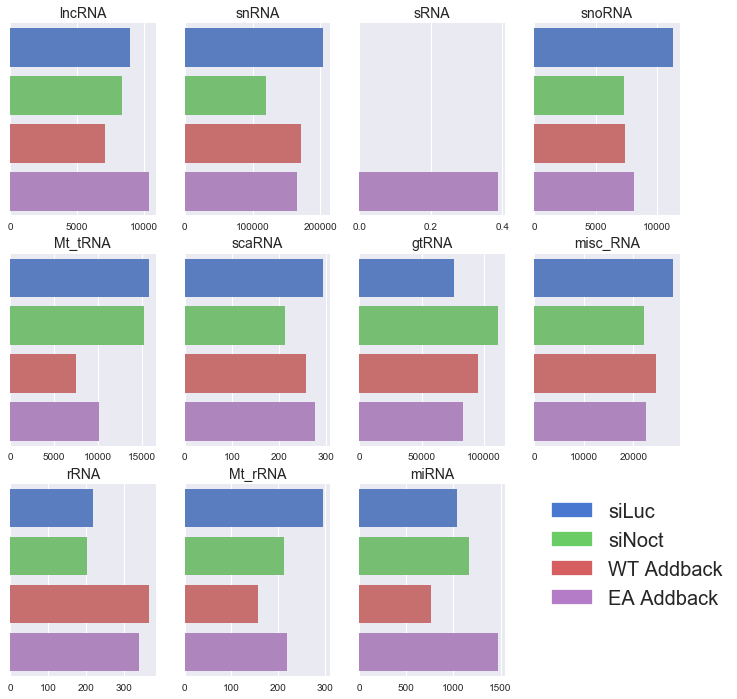

In [157]:
# Plot TPM
col=sns.color_palette("muted")

def plotTPM(df,transcriptList, ax=""):
    df = df[df['Gene'].isin(transcriptList)]
    if ax:
        sns.barplot(y='TPM',x='Gene', data=df, 
                    hue='Source',
                    hue_order=['siLuc','siNoct','WT Addback','EA Addback'], ax=ax)
    else:
        sns.barplot(y='TPM',x='Gene', data=df, hue='Source',hue_order=['siLuc','siNoct','WT Addback','EA Addback'])
def plotCombinedTPM(df, tranType,ax):
    #print(tranType)
    df = df[df['Type']==tranType]
    y = ['siLuc','siNoct','WT Addback','EA Addback']
    x = []
    
    y_axis = ax.axes.get_yaxis()
    y_axis.set_visible(False)
    for dude in y:
        x.append(df[df['Source']==dude]['TPM'].sum())
    sns.barplot(y=y,x=x,ax=ax,palette=col)

#plotTPM(TPM, dec_cans.index[6:10])

#plotCombinedTPM(TPM,trans[11])
#print(trans)

trans = list(set(TPM['Type'].values))
f, axarr = plt.subplots(3,4, figsize=(12,12), )

k=0
for i in range(3):
    for j in range(4):
        if k<len(trans):
            axarr[i,j].set_title(trans[k], fontdict={'fontsize':14})
            k+=1
k=0
for i in range(3):
    for j in range(4):
        if k <len(trans):
            plotCombinedTPM(TPM,trans[k],axarr[i,j])
            k+=1
axarr[2,3].axis('off')
siLuc_patch = mpatches.Patch(color=col[0], label='siLuc')
siNoct_patch = mpatches.Patch(color=col[1], label='siNoct')
WT_patch = mpatches.Patch(color=col[2], label='WT Addback')
EA_patch = mpatches.Patch(color=col[3], label='EA Addback')

plt.legend(handles=[siLuc_patch,siNoct_patch,WT_patch,EA_patch],prop={'size':20}, loc=2)
#plt.savefig('test.tif')


258


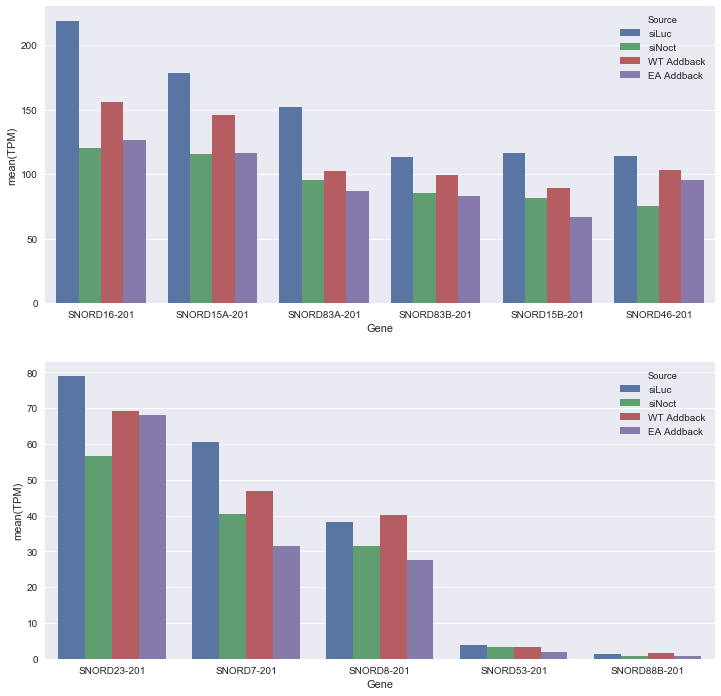

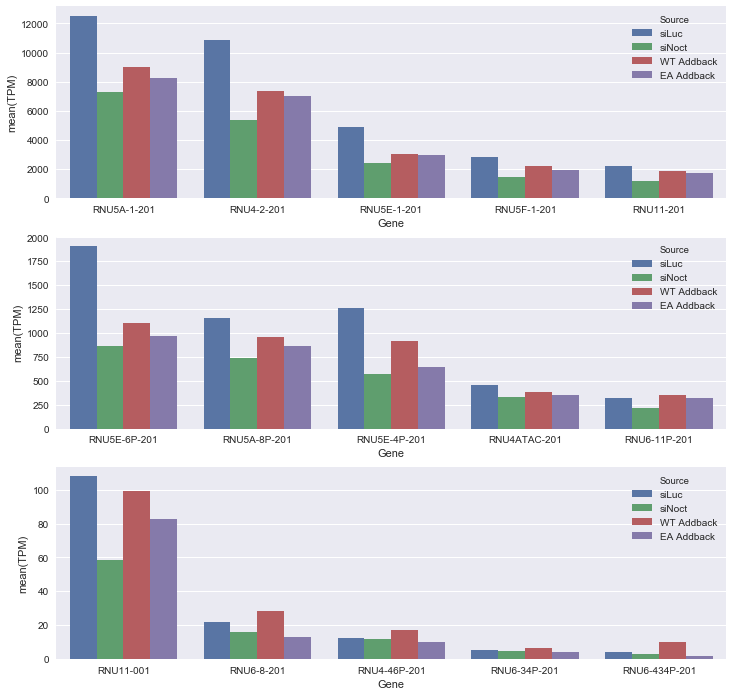

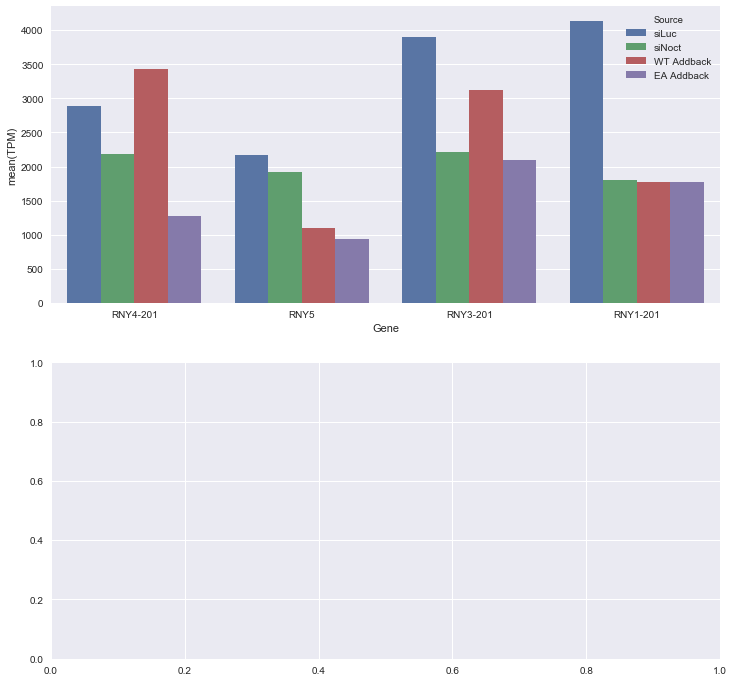

In [196]:
#Maturation Candidate Analysis

#Plot snoRNAs
temp = mat_cans[mat_cans.index.str.contains('SNORD')]

temp=temp.sort_values('siLuc',ascending=False)
tempTPM = TPM[TPM['Gene'].isin(temp.index)]
tempTPM = tempTPM.sort_values(['Source','TPM'],ascending=False)

f, axarr = plt.subplots(2,1,figsize=(12,12))
plotTPM(tempTPM,temp.index[:6],ax=axarr[0])
plotTPM(tempTPM,temp.index[6:12],ax=axarr[1])

#Plot snRNAs
temp = mat_cans[mat_cans.index.str.contains('RNU')]

temp=temp.sort_values('siLuc',ascending=False)
tempTPM = TPM[TPM['Gene'].isin(temp.index)]
tempTPM = tempTPM.sort_values(['Source','TPM'],ascending=False)

f, axarr = plt.subplots(3,1,figsize=(12,12))
plotTPM(tempTPM,temp.index[:5],ax=axarr[0])
plotTPM(tempTPM,temp.index[5:10],ax=axarr[1])
plotTPM(tempTPM,temp.index[10:15],ax=axarr[2])

# Plot YRNAs
f, axarr = plt.subplots(2,1,figsize=(12,12))
plotTPM(TPM,["RNY1-201","RNY3-201","RNY4-201","RNY5"],ax=axarr[0])



In [207]:
#print(len(set(TPM[TPM['Type']=="snoRNA"]['Gene'])))
#245 snoRNA found

len(mat_cans[mat_cans.index.str.contains('SNORD')])
#11 in mat_cans
len(dec_cans[dec_cans.index.str.contains('SNORD')])
# 3 in dec cans
# 15 expected by chance

temp = list(set(TPM[TPM['Type']=='snoRNA']['Gene']))
n=0
for i in range(len(temp)):
    if len(TPM[TPM['Gene']==temp[i]]) == 4: n+=1
#print(n)
#225 in all conditions, 14 expected by chance
#225/16

#snRNAs
print(len(set(TPM[TPM['Type']=="snRNA"]['Gene'])))
# 209 snRNAs found
temp = list(set(TPM[TPM['Type']=='snRNA']['Gene']))
n=0
for i in range(len(temp)):
    if len(TPM[TPM['Gene']==temp[i]]) == 4: n+=1
print(n)
#65 found in all  conditions

len(mat_cans[mat_cans.index.str.contains('RNU')])
#21 in mat_cans
len(dec_cans[dec_cans.index.str.contains('RNU')])
#7 in dec_cans

209
65


7

In [ ]:
# Deprecated code, saved for reference
plt.figure(figsize=(20,20))
df = filtControl[filtControl['Gene'].str.contains('Mt_tRNA')]
values, base = np.histogram(df['3Loc']+df['TailLength'], bins=20, normed=True)
cumulative = np.cumsum(values)
plt.step(base[:-1], cumulative, c='blue')

df = filtKD[filtKD['Gene'].str.contains('Mt_tRNA')]
values, base = np.histogram(df['3Loc']+df['TailLength'], bins=20, normed=True)
cumulative = np.cumsum(values)
plt.step(base[:-1], cumulative, c='green')

df = filtWT[filtWT['Gene'].str.contains('Mt_tRNA')]
values, base = np.histogram(df['3Loc']+df['TailLength'], bins=20, normed=True)
cumulative = np.cumsum(values)
plt.step(base[:-1], cumulative, c='red')

df = filtEA[filtEA['Gene'].str.contains('Mt_tRNA')]
values, base = np.histogram(df['3Loc']+df['TailLength'], bins=20, normed=True)
cumulative = np.cumsum(values)
plt.step(base[:-1], cumulative, c='yellow')

#Cumulative plot of mitochondrial tRNA lengths

In [ ]:
# Deprecated code, saved for reference
plt.figure(figsize=(20,20))
df = filtControl[filtControl['Gene'].str.contains('gtRNA')]
values, base = np.histogram(df['3Loc']+df['TailLength'], bins=20, normed=True)
cumulative = np.cumsum(values)
plt.step(base[:-1], cumulative, c='blue')

df = filtKD[filtKD['Gene'].str.contains('gtRNA')]
values, base = np.histogram(df['3Loc']+df['TailLength'], bins=20, normed=True)
cumulative = np.cumsum(values)
plt.step(base[:-1], cumulative, c='green')

df = filtWT[filtWT['Gene'].str.contains('gtRNA')]
values, base = np.histogram(df['3Loc']+df['TailLength'], bins=20, normed=True)
cumulative = np.cumsum(values)
plt.step(base[:-1], cumulative, c='red')

df = filtEA[filtEA['Gene'].str.contains('gtRNA')]
values, base = np.histogram(df['3Loc']+df['TailLength'], bins=20, normed=True)
cumulative = np.cumsum(values)
plt.step(base[:-1], cumulative, c='yellow')

#cumulative plots of tRNA

In [2]:
print('blah')

blah
